In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import tensorflow as tf
import keras
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception, NASNetLarge, NASNetMobile, InceptionResNetV2,EfficientNetB0
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 100

In [2]:
data = pd.read_csv('../input/k-fold-new-data/5-fold.csv')
test = pd.read_csv('../input/k-fold-new-data/test.csv')

data['id_code'] = data['id_code'].apply(lambda x: x + '.jpg')
test['id_code'] = test['id_code'].apply(lambda x: x + '.jpg')

#fold 0
train_fold0 = data[data['fold_0'] == 'train'][['id_code','diagnosis']]
valid_fold0 = data[data['fold_0'] == 'validation'][['id_code','diagnosis']]

#fold 0
train_fold1 = data[data['fold_1'] == 'train'][['id_code','diagnosis']]
valid_fold1 = data[data['fold_1'] == 'validation'][['id_code','diagnosis']]

#fold 0
train_fold2 = data[data['fold_2'] == 'train'][['id_code','diagnosis']]
valid_fold2 = data[data['fold_2'] == 'validation'][['id_code','diagnosis']]

#fold 0
train_fold3 = data[data['fold_3'] == 'train'][['id_code','diagnosis']]
valid_fold3 = data[data['fold_3'] == 'validation'][['id_code','diagnosis']]

#fold 0
train_fold4 = data[data['fold_4'] == 'train'][['id_code','diagnosis']]
valid_fold4 = data[data['fold_4'] == 'validation'][['id_code','diagnosis']]

In [3]:
# Model parameters
BATCH_SIZE = 10
EPOCHS = 10
WARMUP_EPOCHS = 3
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train_fold0['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

metric_list = ["accuracy"]

In [4]:
def train_model(train_fold, valid_fold, fold):
    
    train_fold['diagnosis'] = train_fold['diagnosis'].astype(str)
    valid_fold['diagnosis'] = valid_fold['diagnosis'].astype(str)
    
    datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

    train_generator=datagen.flow_from_dataframe(
                        dataframe=train_fold,
                        directory='../input/resized-2015-2019-blindness-detection-images/resized train 19',
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

    valid_generator=datagen.flow_from_dataframe(
                        dataframe=valid_fold,
                        directory='../input/resized-2015-2019-blindness-detection-images/resized train 19',
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="categorical",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH))

    test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory='../input/resized-2015-2019-blindness-detection-images/resized train 19',
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH))
    
    
    input_tensor = Input(shape=(HEIGHT, WIDTH, CANAL))
    base_model = Xception(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(5, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    for layer in model.layers:
        layer.trainable = False

    for i in range(-5, 0):
        model.layers[i].trainable = True

    metric_list = ["accuracy"]
    optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
    
    STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

    history_warmup = model.fit(train_generator,
                                     validation_data=valid_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=15,
                                     verbose=1).history
    
    for layer in model.layers:
        layer.trainable = True

    es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

    callback_list = [es, rlrop]
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
    
    history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=40,
                                          callbacks=callback_list,
                                          verbose=1).history
    
    model.save('Xception-'+fold+'sim1.h5')
    
    history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
               'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
               'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
               'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

    ax1.plot(history['loss'], label='Train loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')
    plt.ylim([0,1])
    ax2.plot(history['acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.legend(loc='best')
    ax2.set_title('Accuracy')
    ax2.set_ylim([0,1])
    plt.xlabel('Epochs')


    sns.despine()
    fig.savefig('acc-loss-'+fold)
    
    complete_datagen = ImageDataGenerator(rescale=1./255)
    complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/resized-2015-2019-blindness-detection-images/resized train 19",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

    STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
    train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
    train_preds = [np.argmax(pred) for pred in train_preds]

    
    labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
    cnf_matrix = confusion_matrix(test['diagnosis'].astype('int'), train_preds)
    cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
    plt.figure(figsize=(16, 7))
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
    heatmap = heatmap.get_figure()
    heatmap.savefig('heatmap-'+fold)
    
    print(fold+" - Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, test['diagnosis'].astype('int'), weights='quadratic'))


Found 1757 validated image filenames belonging to 5 classes.
Found 440 validated image filenames belonging to 5 classes.
Found 733 validated image filenames.


2022-07-21 20:27:08.840873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:27:08.960530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:27:08.961347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 20:27:08.963605: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


2022-07-21 20:27:14.103282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-07-21 20:27:18.112457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


175/175 [==============================] - 168s 907ms/step - loss: 0.9694 - accuracy: 0.6714 - val_loss: 0.7163 - val_accuracy: 0.7227
Epoch 2/15
175/175 [==============================] - 146s 835ms/step - loss: 0.7646 - accuracy: 0.7224 - val_loss: 0.7148 - val_accuracy: 0.7273
Epoch 3/15
175/175 [==============================] - 145s 828ms/step - loss: 0.7350 - accuracy: 0.7144 - val_loss: 0.7048 - val_accuracy: 0.7477
Epoch 4/15
175/175 [==============================] - 144s 824ms/step - loss: 0.6970 - accuracy: 0.7304 - val_loss: 0.7032 - val_accuracy: 0.7136
Epoch 5/15
175/175 [==============================] - 146s 831ms/step - loss: 0.7008 - accuracy: 0.7390 - val_loss: 0.6453 - val_accuracy: 0.7455
Epoch 6/15
175/175 [==============================] - 144s 820ms/step - loss: 0.6982 - accuracy: 0.7224 - val_loss: 0.6192 - val_accuracy: 0.7591
Epoch 7/15
175/175 [==============================] - 143s 814ms/step - loss: 0.6609 - accuracy: 0.7516 - val_loss: 0.6227 - val_accura

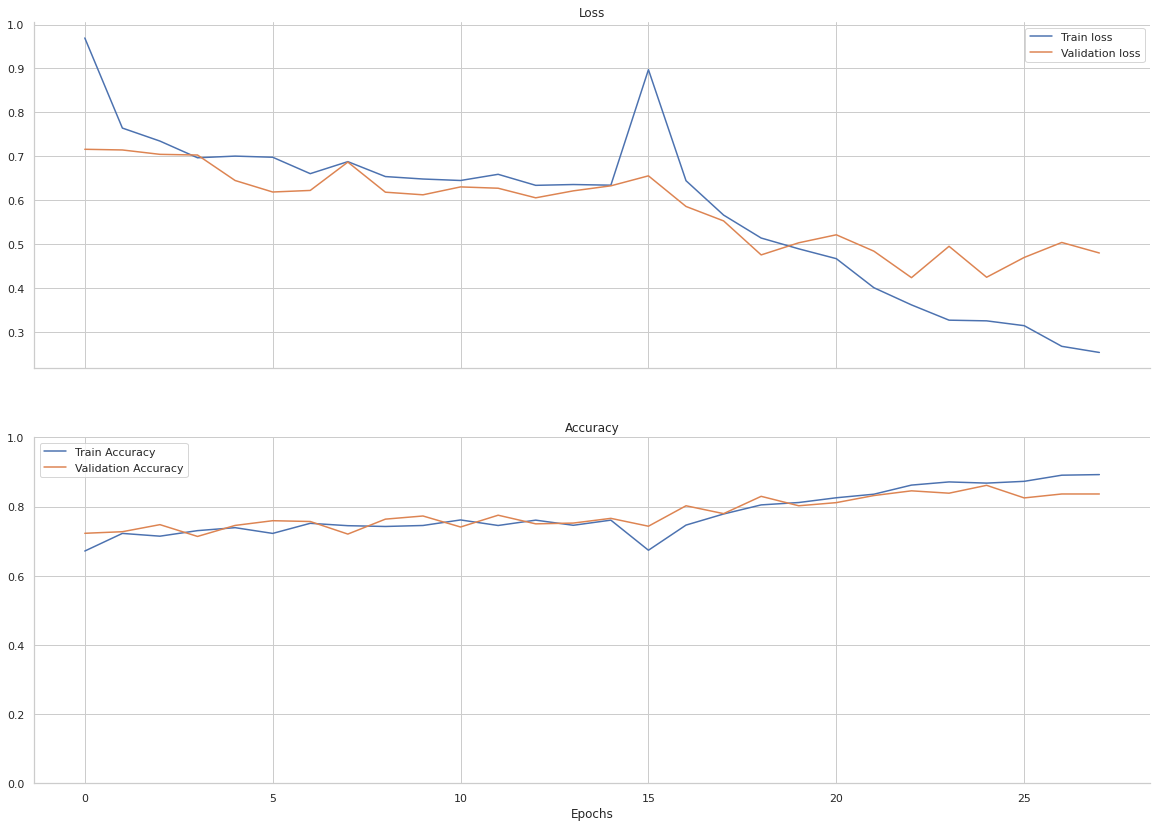

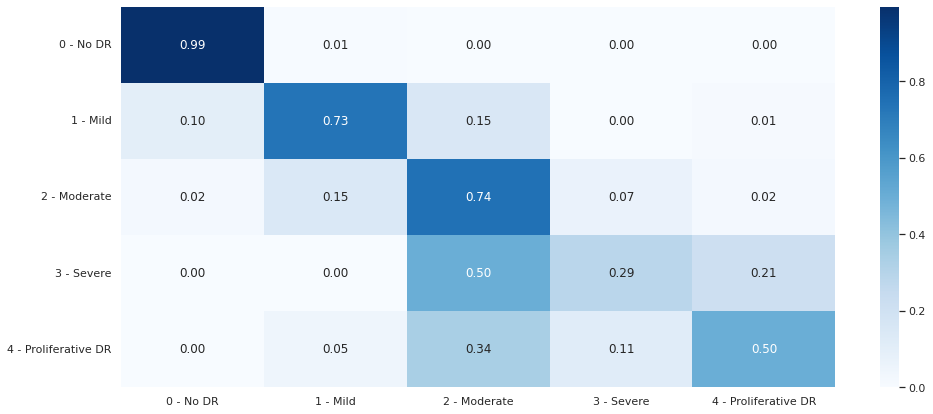

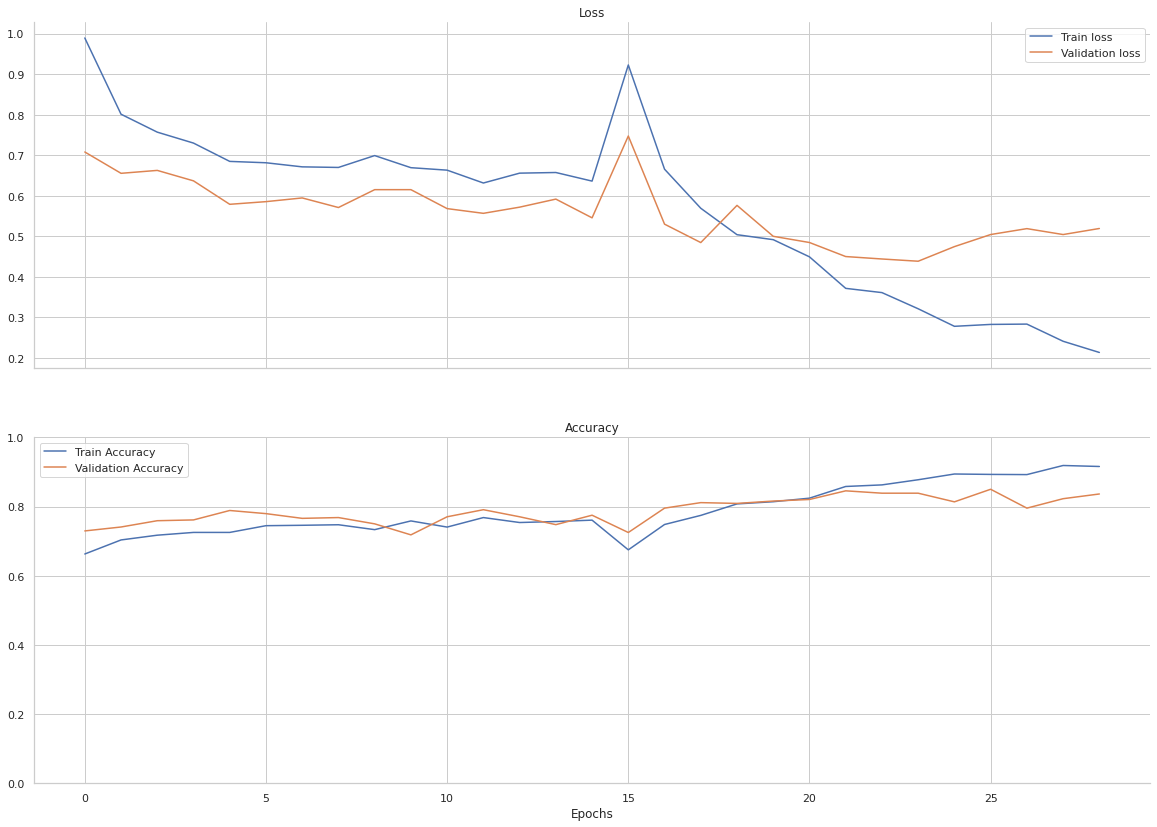

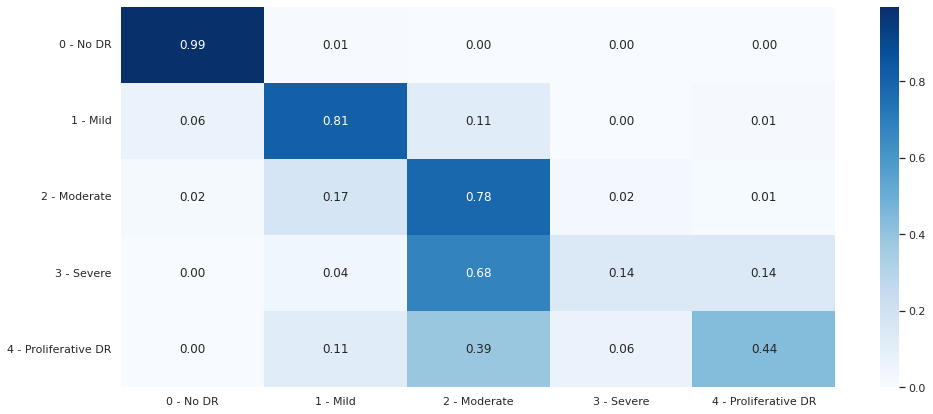

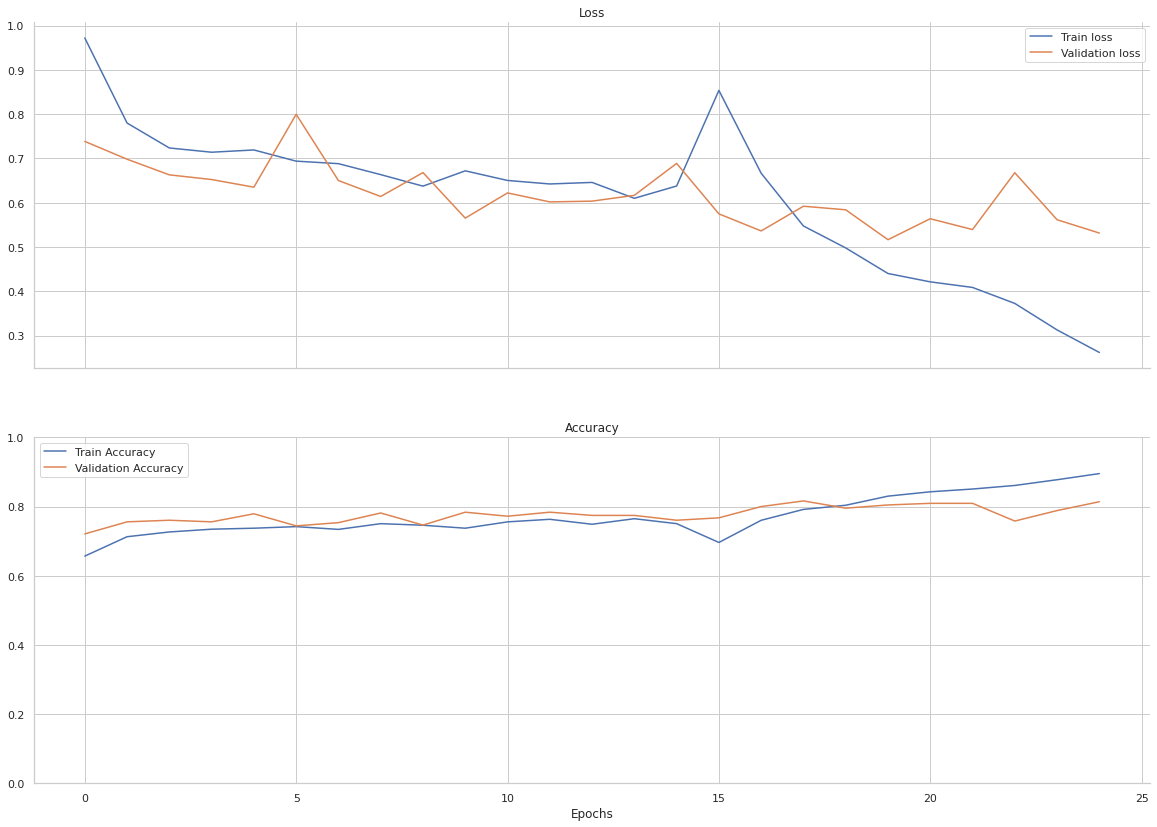

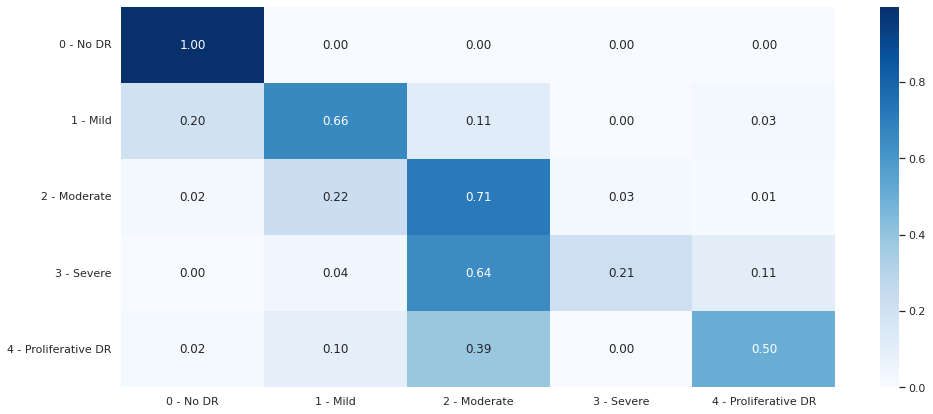

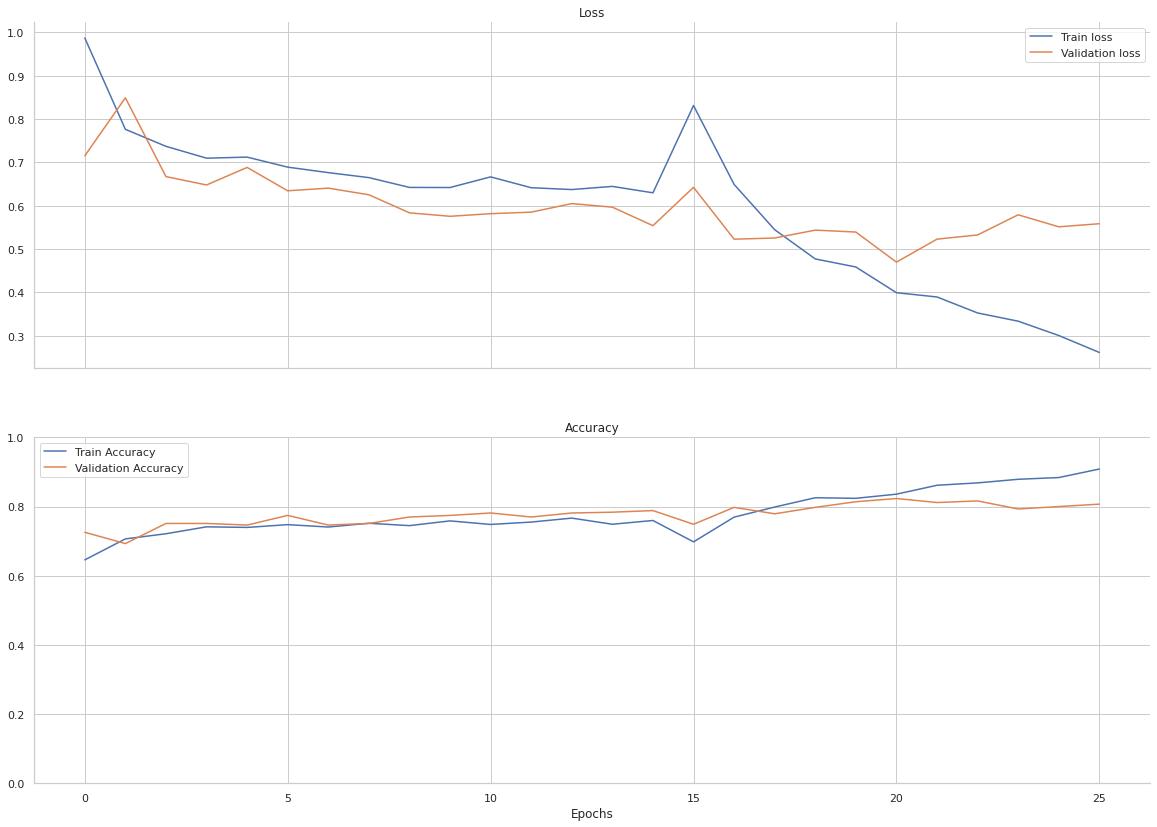

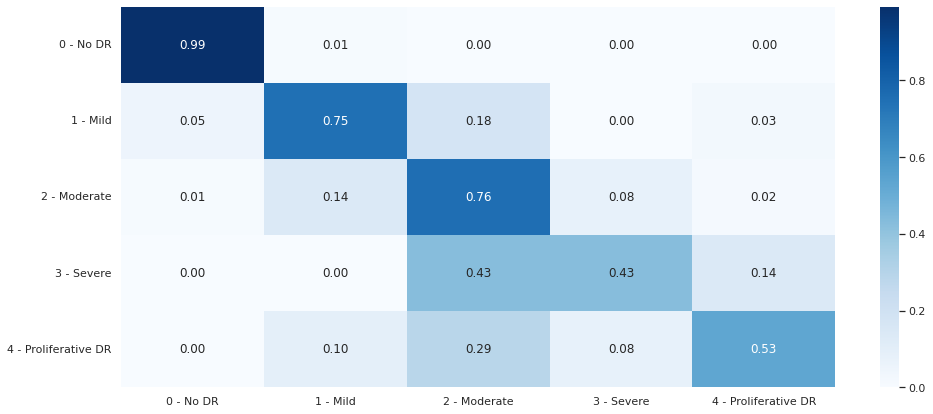

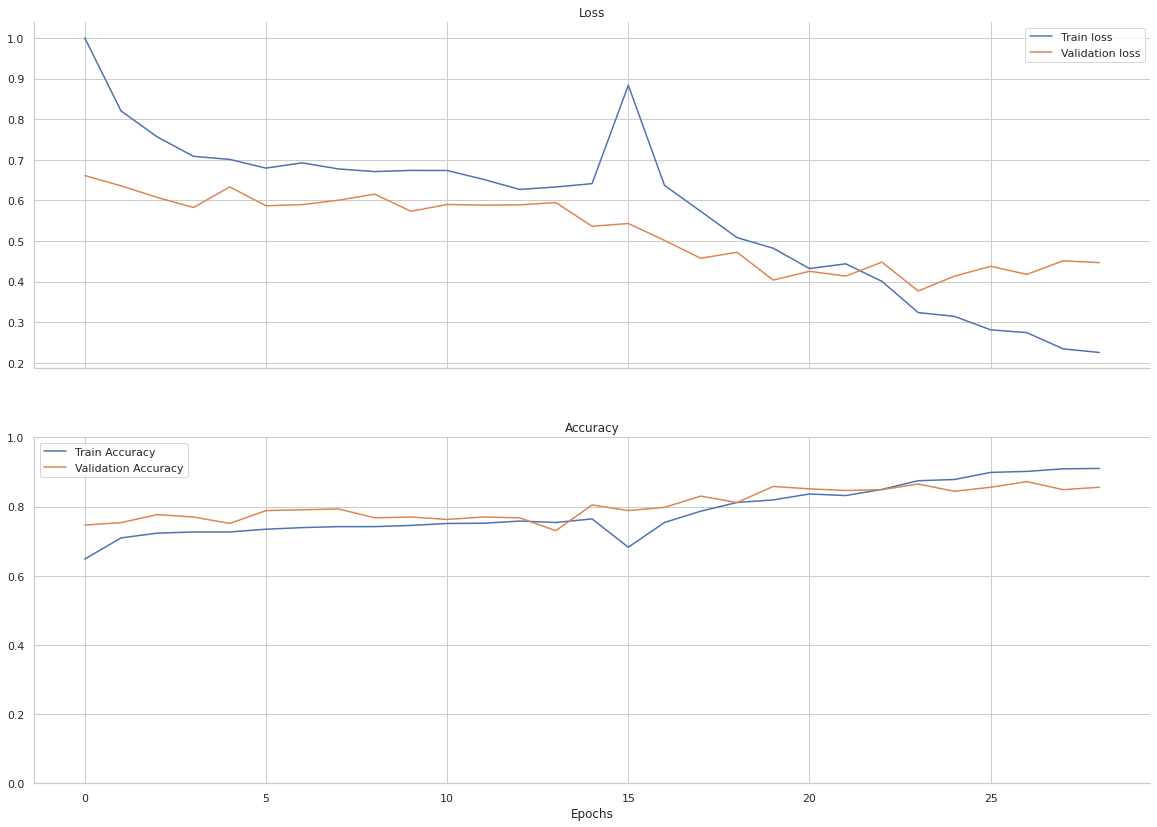

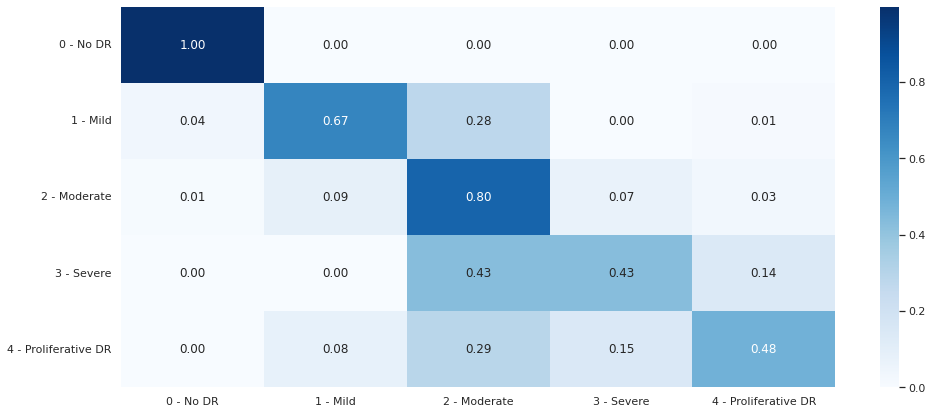

In [5]:
train_model(train_fold0, valid_fold0, 'FOLD0')
train_model(train_fold1, valid_fold1, 'FOLD1')
train_model(train_fold2, valid_fold2, 'FOLD2')
train_model(train_fold3, valid_fold3, 'FOLD3')
train_model(train_fold4, valid_fold4, 'FOLD4')